# PART C: SELF-TAUGHT LEARNING
Implement self-taught learning for Neural Network using the Autoencoder and a 3-layer Neural Network

## Question 3: Self-taught Neural Network Learning

This following part of code is taken from provided codebase to facilitate the process of this assignment

### Part I: Load data sets and required libraries (e.g., H2O)
- Task2C_labeled.csv and Task2C_unlabeled.csv data set are used for training autoencoder
- Task2C_labeled.csv is used for training the classifier

In [60]:
##########################
options(warn=-1)
library(ggplot2)
library(reshape2)
library(h2o)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE, strict_version_check = FALSE)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         34 seconds 48 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.9 
    H2O cluster version age:    12 days  
    H2O cluster name:           phath 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.50 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.1 (2018-07-02) 



In [61]:
# load datasets into h2o instance
labeled.frame <- h2o.importFile(path = 'D:/Master of Data Science/18S2-FIT5201 - Data Analysis Algorithm/Assignment 2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'D:/Master of Data Science/18S2-FIT5201 - Data Analysis Algorithm/Assignment 2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'D:/Master of Data Science/18S2-FIT5201 - Data Analysis Algorithm/Assignment 2/Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA

# we will use labeled.frame and unlabeled.frame for training autoencoders
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])

test.frame[,1] <- as.factor(test.frame$label)

dim(labeled.frame)
dim(train.frame)
dim(test.frame)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


[1]  50 785

[1] 500 784

[1] 1000  785

### Part II: Train an autoencoder with only one hidden layer and change the number of neurons to: 20, 40, ... , 500 

In [62]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [63]:
# create a list to store variants of autoencoder
autoencoder.variants <- list()

for (k in seq(20, 500, 20)){
    # build a neural network classifier based on the training data
    autoencoder.variants[[k/20]] <- h2o.deeplearning(    
        x = 1:ncol(train.frame), # select features
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE, # is it an autoencoder? Yes!
        l2 = 0.1,
        seed=123
    )
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

### Part III: Calculate and record the reconstruction error

In [64]:
# dateframe to record reconstruction error rate
recons.train.error <- data.frame('K' = seq(20,500,20), 'Reconstruction.error'=rep(0,25))

# calculate reconstruction for each model in part II
for (k in seq(20, 500, 20)){
    error <- mean(h2o.anomaly(autoencoder.variants[[k/20]], train.frame))
    recons.train.error[k/20, 'Reconstruction.error'] <- error
}

recons.train.error

K,Reconstruction.error
20,0.03425237
40,0.02158698
60,0.01721310
80,0.01530021
100,0.01519593
120,0.01436655
140,0.01428874
160,0.01421573
180,0.01427426
200,0.01426676


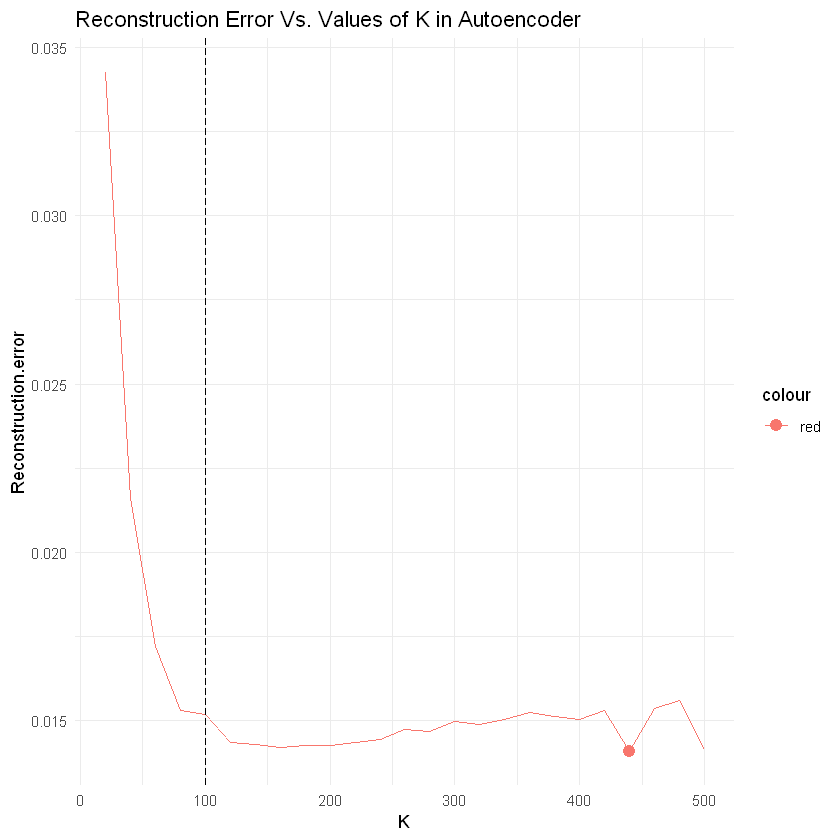

In [74]:
# plot reconstruction error corresponding to value of K
ggplot(data=recons.train.error, aes(x=K, y=Reconstruction.error, color='red')) + geom_line() + 
        geom_point(aes(x=recons.train.error[recons.train.error[,2] == min(recons.train.error$Reconstruction.error),]$K, 
                       y=min(Reconstruction.error)), size=3) +
        geom_vline(xintercept=100, linetype = "longdash") +
        theme_minimal() + ggtitle("Reconstruction Error Vs. Values of K in Autoencoder")

#### Explain findings from the plot above
From the plot, we can see that an autoencoder with one hidden layer and 440 units in that layer will generate the lowest reconstruction error. The error rate starts to decrease significantly at the beginning when we increase the number of units (K) in the hidden layer, then slightly rises again after it reaches the lowest rate.

The structure of autoencoder has a special property, in which the size of input layer is equal to the size of output layer, meaning the algorithm will learn to reconstruct the output from input using encoder and decoder. The encoder learns the most important features from input and compresses it into a latent-space representation (hidden layer). The decoder then reconstructs the input from this hidden layer with an aim to minimize the reconstruction error between input and output. In order to achieve this, we put a constraint on the number of units in hidden layer so that it has smaller dimension than the input and is forced to learn the most important features of the training data. If the dimension of hidden layer is equal or larger than the input, it will simply copy the input forward without learning anything useful. That is why reconstruction error starts to rise again when K approaches the size of input. On the other hand, with small values of K, the autoencoder will excessively reduce useful features from input, resulting in a high reconstruction error. We can observe this in the left part of the first vertical line in the plot.

### Part IV: Use the 3-layer NN to build a classification model with 100 units in the hidden layer
#### Build a new 3-layer neural network with 100 units in the hidden layer

In [66]:
# build a neural network classifier using all the original attributes from the training set
new.NN <- h2o.deeplearning(    
    x = 1:ncol(labeled.frame), # select features
    y = 1,
    training_frame = labeled.frame, # specify the frame (imported file)    
    hidden = c(100), # number of layers and their units
    epochs = 50, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = FALSE, # is it an autoencoder?
    l2 = 0.1,
    seed = 123
)

  |======================================================================| 100%


In [67]:
# use the model built previously to predict the test data
predict.test <- h2o.predict(new.NN, test.frame[,-1])[,1]

# calculate test error
test.error <- error.rate(predict.test, test.frame[,1])
cat('Test error obtained by the 3-layer neural network is:', test.error)

  |======================================================================| 100%
Test error obtained by the 3-layer neural network is: 0.527

### Part V: Build augmented self-taught networks using the models learned in part II

In [68]:
# data frame to record error of each model
selftaught.error <- data.frame('K'=seq(20,500,20), 'Extra.features' = rep(0,25), 'Test.error'=rep(0,25))

# build a neural network classifier based on the labeled training data
for (k in seq(20, 500, 20)){
    # add extra feature with original features
    extra.feature <- h2o.deepfeatures(autoencoder.variants[[k/20]], labeled.frame, layer=1)
    extra.original <- h2o.cbind(labeled.frame, extra.feature) # combine extra features with original ones
    
    # build a neural network classifier based on the labeled training data
    self.taught.nn <- h2o.deeplearning(    
        x = 2:ncol(extra.original), # select all pixels + extra features
        y= 1,
        training_frame = extra.original, # specify the frame (imported file)    
        hidden = c(100), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? Yes!
        l2 = 0.1
    )
    
    # record number of extra feature for each classifier
    selftaught.error[k/20, 'Extra.features'] <- dim(extra.feature)[2]
    
    # predict test data
    prediction <- h2o.predict(self.taught.nn, test.frame[,-1])[,1]
    # calculate and record test error
    selftaught.error[k/20, 'Test.error'] <- error.rate(prediction, test.frame$label)
}

selftaught.error

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

K,Extra.features,Test.error
20,20,0.556
40,40,0.542
60,60,0.577
80,80,0.564
100,100,0.559
120,120,0.591
140,140,0.553
160,160,0.566
180,180,0.660
200,200,0.333


### Part VI: Plot the error rates for the 3-layer neural networks from Step V while the x-axis is the number of extra features and y-axis is the classification error

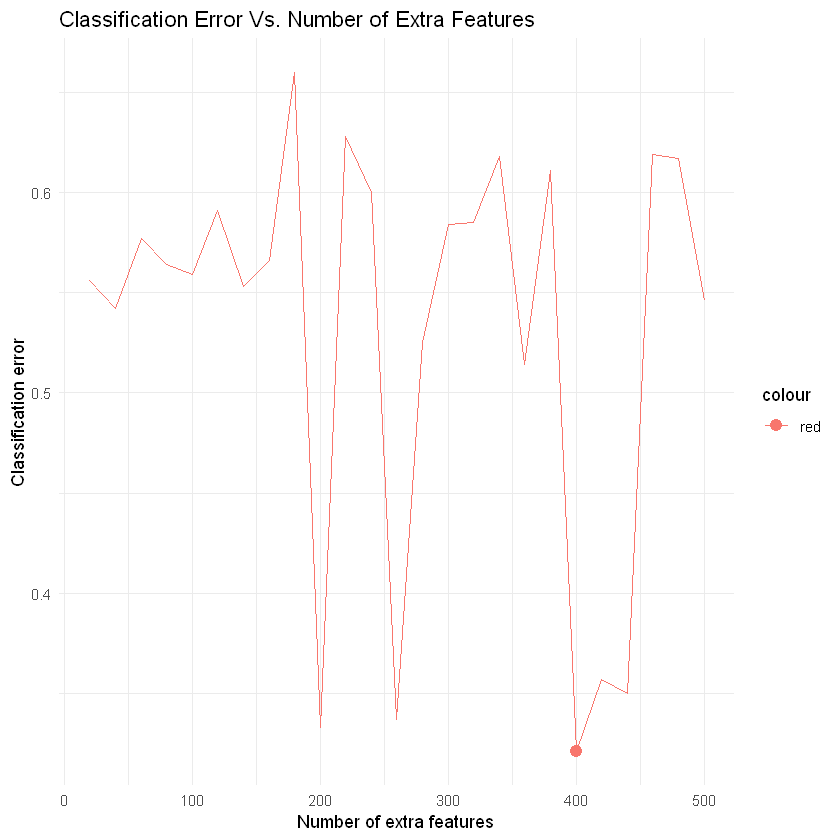

In [69]:
# plot test error corresponding to number of extra features
ggplot(data=selftaught.error, aes(x=Extra.features, y=Test.error, color='red')) + geom_line() + 
        geom_point(aes(x=selftaught.error[selftaught.error[,3] == min(selftaught.error$Test.error),]$Extra.features, 
                       y=min(Test.error)), size=3) +
        xlab(label = 'Number of extra features') +
        ylab(label = 'Classification error') +
        theme_minimal() + ggtitle("Classification Error Vs. Number of Extra Features")

### Part VII: Report the optimum number of units in the middle layer of the autoencoder in terms of the reconstruction and missclassification error.
In the plot of part VI, we can see that the neural network classifier obtains the lowest missclassification error when number of extra features equal 400, while reconstruction error hits the bottom at 0.01408836 with K = 440. Moreover, it is difficult to see any relationship between the trend of these types of errors from the plots since we also recognize that both of them are very low at K = 200 and 260. Therefore, if we need to select an optimum value for the number of units in the middle layer of autoencoder, it is likely to be 400 where we get the lowest missclassification error and also a low reconstruction error.

### Part VIII: Comparing plot from step III and VI 

In [70]:
# combine error rates into a dataframe
combine.error <- as.data.frame(cbind(recons.train.error$K, recons.train.error$Reconstruction.error, 
                                     selftaught.error$Test.error))

# scale error rates and combine them into one dataframe
scaled.error <- as.data.frame(cbind(recons.train.error$K, scale(recons.train.error$Reconstruction.error), 
                                     scale(selftaught.error$Test.error)))

# rename columns
colnames(combine.error) <- c("K", "Reconstruction.error", "Test.error")
colnames(scaled.error) <- c("K", "Scaled.recon.error", "Scaled.test.error")

# transform the dataframes
error.melt <- melt(combine.error, id='K')
scl.error.melt <- melt(scaled.error, id='K')

# rename columns
colnames(error.melt) <- c("K", "Type", "Error.rate")
colnames(scl.error.melt) <- c("K", "Type", "Scaled.error.rate")

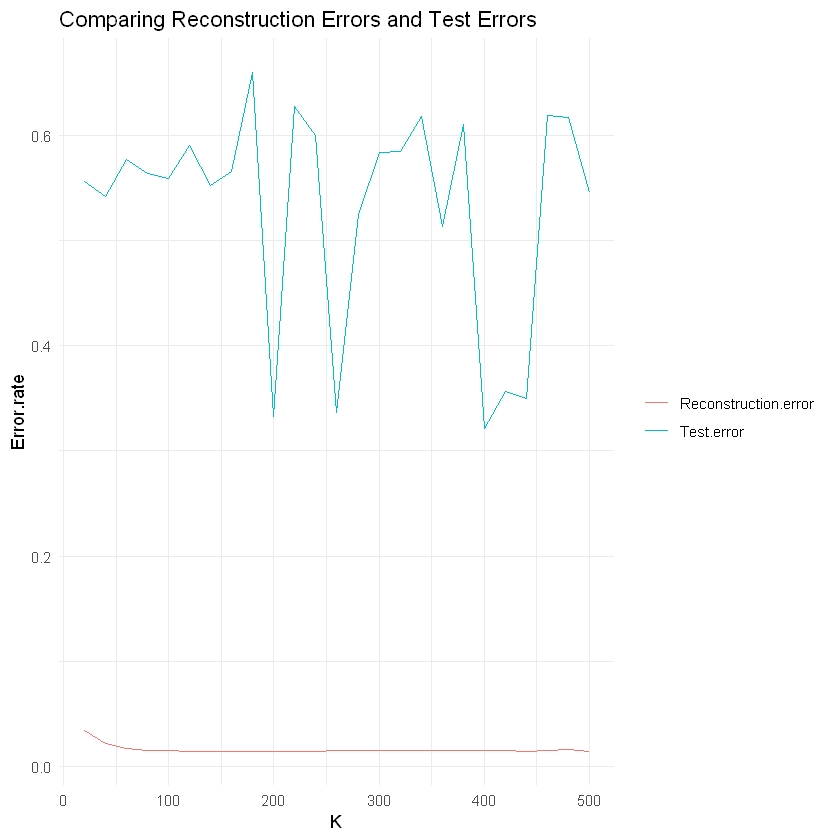

In [71]:
# compare the plot from step III and step VI
ggplot(data=error.melt, aes(x=K, y=Error.rate, color=Type)) + geom_line() +
        scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
        ggtitle("Comparing Reconstruction Errors and Test Errors")

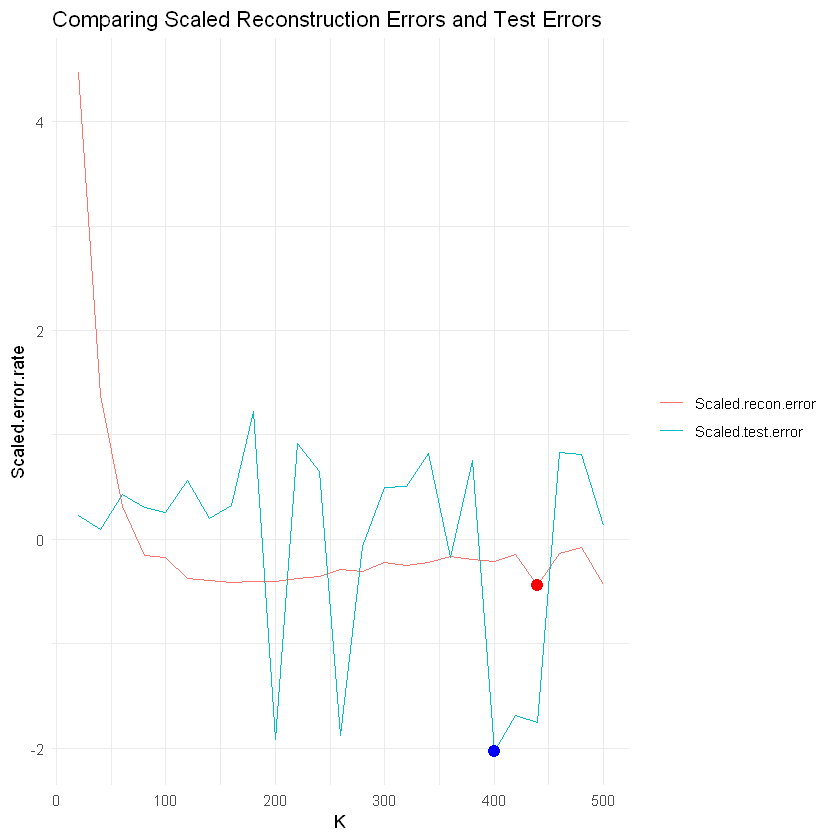

In [77]:
# compare the plot from step III and step VI. All error rates have been scaled for a better visualization
ggplot(data=scl.error.melt, aes(x=K, y=Scaled.error.rate, color=Type)) + geom_line() +
        scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
        geom_point(aes(x= 440, y= scl.error.melt[scl.error.melt$K==440 & scl.error.melt$Type == 'Scaled.recon.error',]$Scaled.error.rate), size=3, color='red') +
        geom_point(aes(x= 400, y= scl.error.melt[scl.error.melt$K==400 & scl.error.melt$Type == 'Scaled.test.error',]$Scaled.error.rate), size=3, color='blue') +
        ggtitle("Comparing Scaled Reconstruction Errors and Test Errors")

From the plot, we can claim that there is not any relationship between the two errors since there is an immense difference in the trend of these errors. While reconstruction error plunges at the beginning, test error is widely fluctuated with increasing K. Another notable point is that the test error is significantly higher than reconstruction error. This can be explained by the difference in the amount of data we feed for each model since we use 500 data points for training autoencoder (train.frame) and only 50 data points (labeled.frame) for 3-layer neural network classifier. We know that the most reliable way to get better performance is to provide an algorithm more data to learn. That is why autoencoder achieves lower error rates than a 3-layer neural network in this case.

In [73]:
dim(labeled.frame)
dim(train.frame)
dim(test.frame)

[1]  50 785

[1] 500 784

[1] 1000  785